In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from mongo import Mongo
import plotly.express as px
from FinMind.data import DataLoader
price_repo = Mongo(db='trading_bot', collection='stock_price')
month_revenue_repo = Mongo(db='trading_bot', collection='month_revenue')
balance_sheet_repo = Mongo(db='trading_bot', collection='balance_sheet')
income_sheet_repo = Mongo(db='trading_bot', collection='income_sheet')
cash_flow_repo = Mongo(db='trading_bot', collection='cash_flow')

# price_data = price_repo.get_data_by_stock_id('1101')
# price_data.dropna(axis=0, inplace=True)
# price_data = price_data[price_data['close']!=0]
# price_data
# month_revenue_data = month_revenue_repo.get_data_by_stock_id('1101')
# income_sheet = income_sheet_repo.get_data_by_stock_id('1101')
# balance_sheet = balance_sheet_repo.get_data_by_stock_id('1101')
# cash_flow = cash_flow_repo.get_data_by_stock_id('1101')
# all_price_data = price_repo.get_all_data()
# all_month_revenue_data = month_revenue_repo.get_all_data()
# all_income_sheet = income_sheet_repo.get_all_data()
# all_balance_sheet = balance_sheet_repo.get_all_data()
# all_cash_flow = cash_flow_repo.get_all_data()

dl = DataLoader()

price_data = dl.taiwan_stock_daily(stock_id='1101', start_date='2013-01-01')
price_data = price_data[price_data['close']!=0]

In [33]:
price_data.isnull().sum()
# no Nan in finmind original data

date                0
stock_id            0
Trading_Volume      0
Trading_money       0
open                0
max                 0
min                 0
close               0
spread              0
Trading_turnover    0
dtype: int64

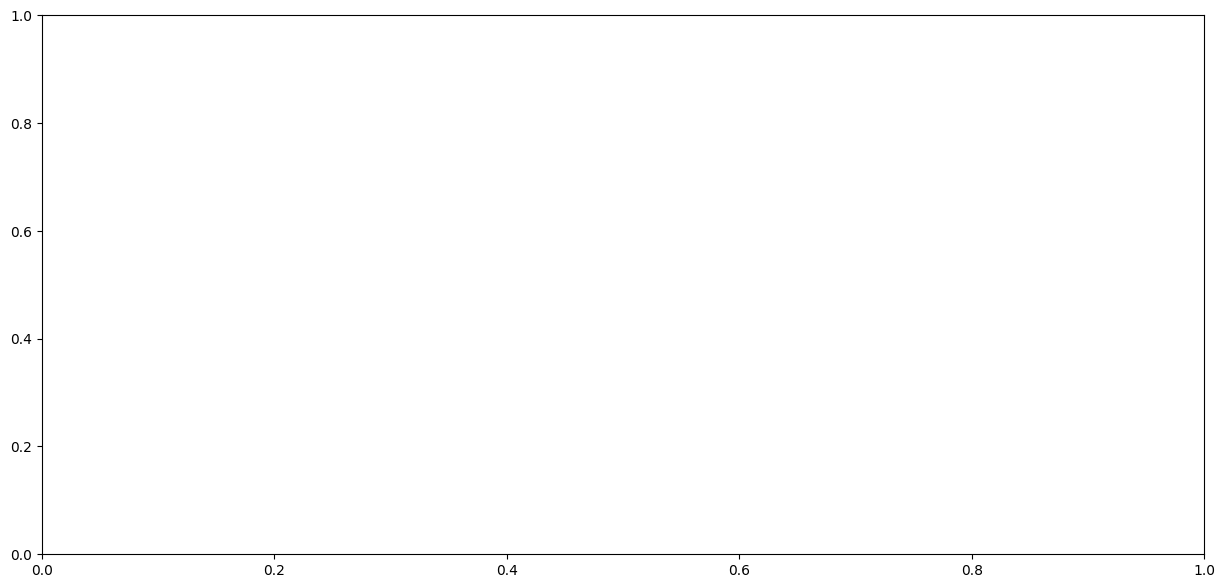

In [23]:
fig, ax = plt.subplots(figsize=(15,7))
sma30 = price_data['close'].rolling(30).mean()[29:]
sma30_std = price_data['close'].rolling(30).std()[29:]
upper_band = sma30+ 2*sma30_std
lower_band = sma30- 2*sma30_std
price = price_data['close'][29:]

# upper_band[:30].plot(ax=ax, color='black')
# lower_band[:30].plot(ax=ax, color='blue')
# sma30[:30].plot(ax=ax, color='orange')
# price[:30].plot(ax=ax, color='red')
# price_data['close'].rolling(30).mean()[120:200].plot(ax=ax, color='black')
# price_data['close'][120:200].plot(ax=ax, color='yellow')
# price_data['close'].rolling(120).mean()[120:200].plot(ax=ax, color='blue')
# upper_band.plot(ax=ax, color='black')
# lower_band.plot(ax=ax, color='blue')
# sma30.plot(ax=ax, color='orange')
# price.plot(ax=ax, color='red')
# Create a DataFrame to hold all series
df = pd.DataFrame({
    'Upper_Band': upper_band,
    'Lower_Band': lower_band,
    'SMA30': sma30,
    'Price': price
})

# Assuming upper_band, lower_band, and price are Pandas Series and indexed similarly
# Creating a DataFrame to hold all these series
df = pd.DataFrame({
    'Upper_Band': upper_band,
    'Lower_Band': lower_band,
    'Price': price
})

# Initialize variables to hold buy and sell signals
df['Buy_Signal'] = False
df['Sell_Signal'] = False

# Initialize variable to hold the state of the portfolio (whether we currently hold the stock or not)
in_position = False

# Loop through DataFrame and identify buy/sell opportunities
for i in range(0, len(df)+1):
    
    # Buy Signal: When price is lower than the lower band
    if df['Price'].iloc[i] < df['Lower_Band'].iloc[i] and  in_position !=True:
        df.at[i, 'Buy_Signal'] = True
        in_position = True  # Now you hold the stock
        
    # Sell Signal: When price is higher than the upper band
    if df['Price'].iloc[i] > df['Upper_Band'].iloc[i] and in_position == True:
        df.at[i, 'Sell_Signal'] = True
        in_position = False  # You have sold the stock

df.dropna(inplace=True)
# # Display DataFrame (Optional)
# print(df)

# Now, df['Buy_Signal'] will indicate where you should buy and df['Sell_Signal'] will indicate where you should sell
px.line(df[['Upper_Band','Lower_Band','Price']])




In [58]:

import pandas as pd
def bollinger_band(stock_id):
    dl = DataLoader()

    price_data = dl.taiwan_stock_daily(stock_id=str(stock_id), start_date='2013-01-01')
    price_data = price_data[price_data['close']!=0]
    



    
    sma30 = price_data['close'].rolling(30).mean()[29:]
    sma30_std = price_data['close'].rolling(30).std()[29:]
    upper_band = sma30+ 2*sma30_std
    lower_band = sma30- 2*sma30_std
    price = price_data['close'][29:]

    #reset the index so that it start from 0
    sma30 = sma30.reset_index(drop=True)
    sma30_std = sma30_std.reset_index(drop=True)
    upper_band = upper_band.reset_index(drop=True)
    lower_band = lower_band.reset_index(drop=True)
    price = price.reset_index(drop=True)


    # Assuming upper_band, lower_band, and price are Pandas Series and indexed similarly
    # Creating a DataFrame to hold all these series
    df = pd.DataFrame({
        'Upper_Band': upper_band,
        'Lower_Band': lower_band,
        'Price': price
    })

    # Initialize variables to hold buy and sell signals
    df['Buy_Signal'] = False
    df['Sell_Signal'] = False
    # Initial capital
    initial_capital = 10000.0
    final_capital = initial_capital

    # Calculate the number of years
    time_period = 10#(price_data.index[-1] - price_data.index[0]).days / 365.25

    # Initialize variable to hold the state of the portfolio (whether we currently hold the stock or not)
    in_position = False

    # Loop through DataFrame and identify buy/sell opportunities
    for i in range(0, len(df)):
        
        # Buy Signal: When price is lower than the lower band
        if df['Price'].iloc[i] < df['Lower_Band'].iloc[i] and not in_position:
            df.at[i,'Buy_Signal'] = True
            in_position = True  # Now you hold the stock
            buy_price = df['Price'].iloc[i]  # Remember the buy price
            
        # Sell Signal: When price is higher than the upper band
        if df['Price'].iloc[i] > df['Upper_Band'].iloc[i] and in_position:
            df.at[i,'Sell_Signal'] = True
            in_position = False  # You have sold the stock
            
            # Calculate profit from this transaction and add it to the final capital
            sell_price = df['Price'].iloc[i]
            final_capital += (sell_price - buy_price) * (final_capital / buy_price)

    # Calculate annualized return
    annualized_return = ((final_capital / initial_capital) ** (1 / time_period) - 1) * 100

    # Display the annualized return
    print(f'Annualized Return: {annualized_return:.2f}%')






    # Create a scatter plot for price
    fig = px.line(df, x=df.index, y='Price', title='Buy and Sell Signal Plot')

    # Add line plot for upper and lower bands
    fig.add_scatter(x=df.index, y=df['Upper_Band'], mode='lines', name='Upper Band')
    fig.add_scatter(x=df.index, y=df['Lower_Band'], mode='lines', name='Lower Band')

    # Filter out buy and sell signals from df
    buy_signals = df[df['Buy_Signal']]
    sell_signals = df[df['Sell_Signal']]

    # Add buy signals to the plot
    fig.add_scatter(x=buy_signals.index, y=buy_signals['Price'], mode='markers', marker=dict(size=10, color='green'), name='Buy Signal')

    # Add sell signals to the plot
    fig.add_scatter(x=sell_signals.index, y=sell_signals['Price'], mode='markers', marker=dict(size=10, color='red'), name='Sell Signal')

    # Show plot
    fig.show()

    print(f'initial_investment : {initial_capital}')
    print(f'final_investment : {final_capital}')

In [ ]:

import pandas as pd
def bollinger_band(stock_id, optimise=False):
    dl = DataLoader()

    price_data = dl.taiwan_stock_daily(stock_id=str(stock_id), start_date='2013-01-01')
    price_data = price_data[price_data['close']!=0]
    



    if optimise:
        for i in range(20, 100, 10):
    else:
        sma30 = price_data['close'].rolling(30).mean()[29:].reset_index(drop=True)
        sma30_std = price_data['close'].rolling(30).std()[29:].reset_index(drop=True)
        upper_band = sma30+ 2*sma30_std.reset_index(drop=True)
        lower_band = sma30- 2*sma30_std.reset_index(drop=True)
        price = price_data['close'][29:].reset_index(drop=True)


    # Assuming upper_band, lower_band, and price are Pandas Series and indexed similarly
    # Creating a DataFrame to hold all these series
    df = pd.DataFrame({
        'Upper_Band': upper_band,
        'Lower_Band': lower_band,
        'Price': price
    })

    # Initialize variables to hold buy and sell signals
    df['Buy_Signal'] = False
    df['Sell_Signal'] = False
    # Initial capital
    initial_capital = 10000.0
    final_capital = initial_capital

    # Calculate the number of years
    time_period = 10#(price_data.index[-1] - price_data.index[0]).days / 365.25

    # Initialize variable to hold the state of the portfolio (whether we currently hold the stock or not)
    in_position = False

    # Loop through DataFrame and identify buy/sell opportunities
    for i in range(0, len(df)):
        
        # Buy Signal: When price is lower than the lower band
        if df['Price'].iloc[i] < df['Lower_Band'].iloc[i] and not in_position:
            df.at[i,'Buy_Signal'] = True
            in_position = True  # Now you hold the stock
            buy_price = df['Price'].iloc[i]  # Remember the buy price
            
        # Sell Signal: When price is higher than the upper band
        if df['Price'].iloc[i] > df['Upper_Band'].iloc[i] and in_position:
            df.at[i,'Sell_Signal'] = True
            in_position = False  # You have sold the stock
            
            # Calculate profit from this transaction and add it to the final capital
            sell_price = df['Price'].iloc[i]
            final_capital += (sell_price - buy_price) * (final_capital / buy_price)

    # Calculate annualized return
    annualized_return = ((final_capital / initial_capital) ** (1 / time_period) - 1) * 100

    # Display the annualized return
    print(f'Annualized Return: {annualized_return:.2f}%')






    # Create a scatter plot for price
    fig = px.line(df, x=df.index, y='Price', title='Buy and Sell Signal Plot')

    # Add line plot for upper and lower bands
    fig.add_scatter(x=df.index, y=df['Upper_Band'], mode='lines', name='Upper Band')
    fig.add_scatter(x=df.index, y=df['Lower_Band'], mode='lines', name='Lower Band')

    # Filter out buy and sell signals from df
    buy_signals = df[df['Buy_Signal']]
    sell_signals = df[df['Sell_Signal']]

    # Add buy signals to the plot
    fig.add_scatter(x=buy_signals.index, y=buy_signals['Price'], mode='markers', marker=dict(size=10, color='green'), name='Buy Signal')

    # Add sell signals to the plot
    fig.add_scatter(x=sell_signals.index, y=sell_signals['Price'], mode='markers', marker=dict(size=10, color='red'), name='Sell Signal')

    # Show plot
    fig.show()

    print(f'initial_investment : {initial_capital}')
    print(f'final_investment : {final_capital}')

In [59]:
bollinger_band('2330')

Annualized Return: 5.90%


initial_investment : 10000.0
final_investment : 17733.283209060315


In [59]:
df['Sell_Signal'].sum()

1

In [51]:
df.at[0,'Buy_Signal'] = True
df

,Upper_Band,Lower_Band,Price,Buy_Signal,Sell_Signal
29,40.353775,37.812891,37.40,False,False
30,40.364574,37.752093,38.25,False,False
31,40.368097,37.721903,38.45,False,False
32,40.376954,37.659712,38.20,False,False
33,40.407105,37.559561,37.85,False,False
...,...,...,...,...,...
2641,35.618113,31.531887,31.65,False,False
2642,35.635922,31.324078,31.50,False,False
2643,35.648633,31.141367,31.55,False,False
1,NaN,NaN,NaN,True,NaN


In [ ]:
'].iloc[0]

In [8]:
import plotly.express as px

# Sample DataFrame df with columns 'Price', 'Lower_Band', 'Upper_Band', 'Buy_Signal', 'Sell_Signal'

# Create a scatter plot for price
fig = px.scatter(df, x=df.index, y='Price', title='Buy and Sell Signal Plot')

# Add line plot for upper and lower bands
fig.add_scatter(x=df.index, y=df['Upper_Band'], mode='lines', name='Upper Band')
fig.add_scatter(x=df.index, y=df['Lower_Band'], mode='lines', name='Lower Band')

# Filter out buy and sell signals from df
buy_signals = df[df['Buy_Signal']]
sell_signals = df[df['Sell_Signal']]

# Add buy signals to the plot
fig.add_scatter(x=buy_signals.index, y=buy_signals['Price'], mode='markers', marker=dict(size=10, color='green'), name='Buy Signal')

# Add sell signals to the plot
fig.add_scatter(x=sell_signals.index, y=sell_signals['Price'], mode='markers', marker=dict(size=10, color='red'), name='Sell Signal')

# Show plot
fig.show()


ValueError: Cannot mask with non-boolean array containing NA / NaN values